In [2]:
import os
import argparse
import json
import numpy as np
import torch
import torch.nn as nn

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap                         

from utils.util import find_max_epoch, print_size, training_loss, calc_diffusion_hyperparams
from utils.util import get_mask_mnr, get_mask_bm, get_mask_rm

from imputers.DiffWaveImputer import DiffWaveImputer
from imputers.SSSDSAImputer import SSSDSAImputer
from imputers.SSSDS4Imputer import SSSDS4Imputer

import time

In [3]:
from ae.timegan import Net

input_size = 6
hidden_size = 24
num_layers = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


embedder = Net(input_size, hidden_size, 3, num_layers).to(device)
recovery = Net(3, hidden_size, 6, num_layers).to(device)

embedder.load_state_dict(torch.load( "./ae/embedder.pt"))
recovery.load_state_dict(torch.load( "./ae/recovery.pt"))

# embedder.eval()
# recovery.eval()

print(embedder)
print(recovery)

Net(
  (rnn): GRU(6, 24, num_layers=3, batch_first=True)
  (linear): Linear(in_features=24, out_features=3, bias=True)
)
Net(
  (rnn): GRU(3, 24, num_layers=3, batch_first=True)
  (linear): Linear(in_features=24, out_features=6, bias=True)
)


In [4]:
parser = argparse.ArgumentParser()
# parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4.json', help='JSON file for configuration')
parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4-sp500.json')  

# parser.add_argument('-c', '--config', type=str, default='./config/config_DiffWave-sp500.json') 
                                                                                                                                                       
args = parser.parse_args(args=[])
print(args)

with open(args.config) as f:
    data = f.read()

config = json.loads(data)
print(config)

Namespace(config='./config/config_SSSDS4-sp500.json')
{'diffusion_config': {'T': 200, 'beta_0': 0.0001, 'beta_T': 0.02}, 'wavenet_config': {'in_channels': 6, 'out_channels': 6, 'num_res_layers': 36, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}, 'train_config': {'output_directory': './results/sp500/90', 'ckpt_iter': 'max', 'iters_per_ckpt': 500, 'iters_per_logging': 500, 'n_iters': 1000, 'learning_rate': 0.0002, 'only_generate_missing': 1, 'use_model': 2, 'masking': 'rm', 'missing_k': 20}, 'trainset_config': {'train_data_path': './datasets/sp500.npy', 'test_data_path': './datasets/sp500.npy', 'segment_length': 100, 'sampling_rate': 100}, 'gen_config': {'output_directory': './results/sp500/90', 'ckpt_path': './results/sp500/90/'}}


In [5]:
train_config = config["train_config"]  # training parameters

global trainset_config
trainset_config = config["trainset_config"]  # to load trainset

global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(
                      **diffusion_config)  #   dictionary of all diffusion hyperparameters

global model_config

if train_config['use_model'] == 0:
    model_config = config['wavenet_config']
elif train_config['use_model'] == 1:
    model_config = config['sashimi_config']
elif train_config['use_model'] == 2:
    model_config = config['wavenet_config']
    
    
# print(diffusion_hyperparams)
print(train_config)
print(model_config)


model_config['in_channels']=3   
model_config['out_channels']=3   
model_config['num_res_layers']=18        
model_config['res_channels']=128          
model_config['skip_channels']=128 

print(model_config)

{'output_directory': './results/sp500/90', 'ckpt_iter': 'max', 'iters_per_ckpt': 500, 'iters_per_logging': 500, 'n_iters': 1000, 'learning_rate': 0.0002, 'only_generate_missing': 1, 'use_model': 2, 'masking': 'rm', 'missing_k': 20}
{'in_channels': 6, 'out_channels': 6, 'num_res_layers': 36, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}
{'in_channels': 3, 'out_channels': 3, 'num_res_layers': 18, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}


In [6]:
output_directory = './results/mujoco/90'
ckpt_iter = 'max'
n_iters = 10000
iters_per_ckpt = 100
iters_per_logging = 100
# batch_size_per_gpu                
learning_rate = 0.0002

use_model = 2

only_generate_missing = 1       
masking = 'rm'              
missing_k = 20

In [7]:
local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])
print(local_path)


output_directory = os.path.join(output_directory, local_path)
if not os.path.isdir(output_directory):
    os.makedirs(output_directory)
    os.chmod(output_directory, 0o775)              
print("output directory", output_directory, flush=True)

# map diffusion hyperparameters to gpu
for key in diffusion_hyperparams:
    if key != "T":
        diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()
        
        
# predefine model
if use_model == 0:
    net = DiffWaveImputer(**model_config).cuda()
elif use_model == 1:
    net = SSSDSAImputer(**model_config).cuda()
elif use_model == 2:
    net = SSSDS4Imputer(**model_config).cuda()   
else:
    print('Model chosen not available.')
    

print_size(net)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

T200_beta00.0001_betaT0.02
output directory ./results/mujoco/90\T200_beta00.0001_betaT0.02
SSSDS4Imputer Parameters: 7.518723M


(5775, 30, 6)
torch.Size([30, 3])


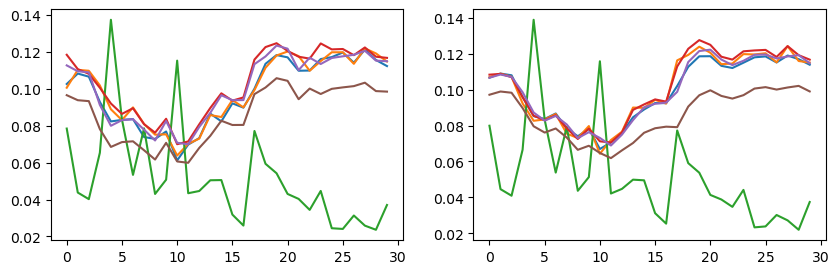

In [8]:

training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
print(training_data.shape)
# print(training_data[0])



data = torch.from_numpy(training_data[35]).float().to(device)
emb = embedder(data)       # [30, 24]
print(emb.shape)
out = recovery(emb) 


plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(data.cpu())

plt.subplot(1,2,2)
plt.plot(out.cpu().detach().numpy())


In [9]:
# training_data = np.split(training_data, 160, 0)    
training_data = np.split(training_data, 55, 0)      
print(len(training_data), training_data[0].shape)

training_data = np.array(training_data)
# print(training_data.shape)

training_data = torch.from_numpy(training_data).float().cuda()
print(training_data.shape)

# for batch in training_data:
#     print(batch.shape)

55 (105, 30, 6)
torch.Size([55, 105, 30, 6])


In [13]:
missing_k = 20                   
iters = 0
loss_list=[]

n_iters = 10000
while iters < n_iters + 1:

    start_time = time.time()
    
    for batch in training_data:      
        
#

        with torch.no_grad():              
            batch = embedder(batch)               
    

        transposed_mask = get_mask_rm(batch[0], missing_k)     

        mask = transposed_mask.permute(1, 0)    

        mask = mask.repeat(batch.size()[0], 1, 1).float().cuda()  

        loss_mask = ~mask.bool()        

        batch = batch.permute(0, 2, 1)   
        optimizer.zero_grad()

        X = batch, batch, mask, loss_mask    
        
        loss = training_loss(net, nn.MSELoss(), X, diffusion_hyperparams,
                             only_generate_missing=only_generate_missing)

        loss.backward()
        optimizer.step()
        
        
        if iters % iters_per_logging == 0:
                print("iteration: {} \tloss: {}".format(iters, loss.item()))
                
#         if iters > 0 and iters % iters_per_ckpt == 0:
#                 checkpoint_name = '{}.pkl'.format(iters)
#                 torch.save({'model_state_dict': net.state_dict(),
#                             'optimizer_state_dict': optimizer.state_dict()},
#                            os.path.join(output_directory, checkpoint_name))
    
        loss_list.append(loss.item())
        
        iters += 1
        
    end_time = time.time()
    execution_time = end_time - start_time   
    print(execution_time)   
  

iteration: 0 	loss: 0.9893648028373718
7.344759225845337
iteration: 100 	loss: 0.06448474526405334
5.283350467681885
5.246562480926514
iteration: 200 	loss: 0.0445290133357048
5.518941164016724
5.34057879447937


KeyboardInterrupt: 

In [10]:
# torch.save( net.state_dict(),"./sp500_S4_latent_iter_10000.pth" )

net = SSSDS4Imputer(**model_config).cuda()
net.load_state_dict(torch.load( "./sp500_S4_latent_iter_10000.pth"))

# net.eval()

<All keys matched successfully>

In [12]:
def std_normal(size):
    """
    Generate the standard Gaussian variable of a certain size
    """
    return torch.normal(0, 1, size=size).cuda()


size=(5775,3,30)

_dh = diffusion_hyperparams
T, Alpha, Alpha_bar, Sigma = _dh["T"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Sigma"]

assert len(Alpha) == T
assert len(Alpha_bar) == T
assert len(Sigma) == T
assert len(size) == 3

# print(T, Alpha)

x = std_normal(size)      
cond = 1
mask = 1

print(x.shape)

# x = embedder(x)

torch.Size([5775, 3, 30])


In [13]:
with torch.no_grad(): 
        
        for t in range(T - 1, -1, -1):        
                
            diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step
                       
            epsilon_theta = net((x, cond, mask, diffusion_steps,))  # predict \epsilon according to \epsilon_\theta
             
            x = (x - (1 - Alpha[t]) / torch.sqrt(1 - Alpha_bar[t]) * epsilon_theta) / torch.sqrt(Alpha[t])
            
            if t > 0:
                x = x + Sigma[t] * std_normal(size)  
                              

In [14]:
print(x.shape)

result = x.permute(0, 2, 1)
print(result.shape)

result = recovery(result)
print(result.shape)

torch.Size([5775, 3, 30])
torch.Size([5775, 30, 3])
torch.Size([5775, 30, 6])


(5775, 180)
(5775, 2)


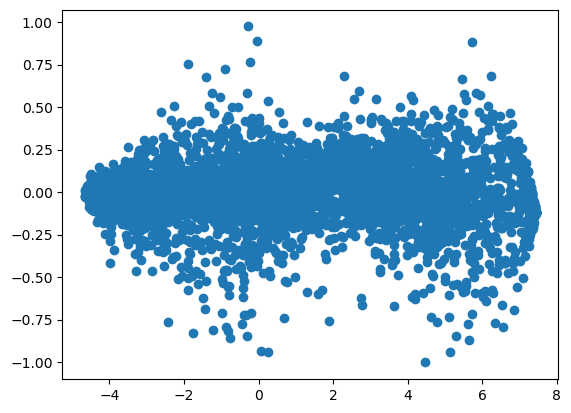

In [15]:
result = result.detach().cpu().numpy().reshape(5775,-1)
# result = result.cpu().numpy().reshape(-1,14)[0:2000]
print(result.shape)


pca = PCA(2)
pca_res1 = pca.fit_transform(result)
print(pca_res1.shape)

plt.figure()
plt.scatter(pca_res1[:,0],pca_res1[:,1])

(5775, 30, 6)
(5775, 180)
(5775, 2)


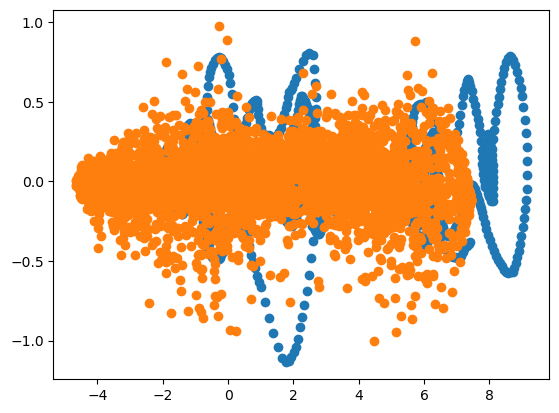

In [16]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
print(training_data.shape)
# print(training_data[0])

# ori_data = training_data.reshape(-1,6)
ori_data = training_data.reshape(5775,-1)
print(ori_data.shape)
# print(ori_data[0:3])


pca = PCA(2)
pca_res = pca.fit_transform(ori_data)
print(pca_res.shape)

plt.figure()
plt.scatter(pca_res[:,0],pca_res[:,1])
plt.scatter(pca_res1[:,0],pca_res1[:,1])

In [17]:
concat_data = np.concatenate((result, ori_data), axis=0)
print(concat_data.shape)

tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    
tsne_results = tsne.fit_transform(concat_data) 

(11550, 180)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11550 samples in 0.002s...


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 11550 samples in 0.379s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11550
[t-SNE] Computed conditional probabilities for sample 2000 / 11550
[t-SNE] Computed conditional probabilities for sample 3000 / 11550
[t-SNE] Computed conditional probabilities for sample 4000 / 11550
[t-SNE] Computed conditional probabilities for sample 5000 / 11550
[t-SNE] Computed conditional probabilities for sample 6000 / 11550
[t-SNE] Computed conditional probabilities for sample 7000 / 11550
[t-SNE] Computed conditional probabilities for sample 8000 / 11550
[t-SNE] Computed conditional probabilities for sample 9000 / 11550
[t-SNE] Computed conditional probabilities for sample 10000 / 11550
[t-SNE] Computed conditional probabilities for sample 11000 / 11550
[t-SNE] Computed conditional probabilities for sample 11550 / 11550
[t-SNE] Mean sigma: 0.072365
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.639656
[t-SNE] KL divergence after 

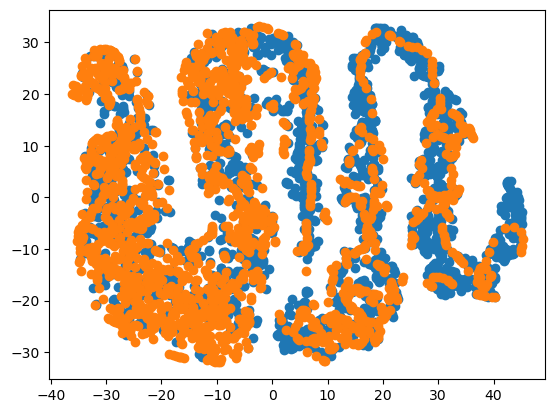

In [18]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[5775:7775,0],tsne_results[5775:7775,1])
# plt.savefig('tsne',dpi=500)


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(11550, 2)


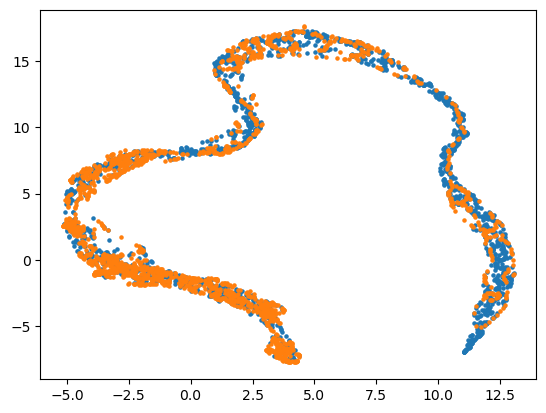

In [19]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(concat_data)
print(embedding.shape)

# plt.figure()
# plt.scatter(embedding[:, 0], embedding[:, 1],  cmap='Spectral', s=5)

plt.figure()
plt.scatter(embedding[:2000, 0], embedding[:2000, 1],  cmap='Spectral', s=5)
plt.scatter(embedding[5775:7775, 0], embedding[5775:7775, 1],  cmap='Spectral', s=5)

In [20]:
# x = current_sample.cpu().numpy()
# print(x.shape,current_sample.shape)

ori_data = training_data
generated_data = x.permute(0, 2, 1).cpu().numpy()
print(ori_data.shape, generated_data.shape)

# x = torch.randn(4000,30,6).numpy()    


anal_sample_no = min([4000, len(ori_data)])       
idx = np.random.permutation(len(ori_data))[:anal_sample_no]


ori_data = np.asarray(ori_data)
generated_data = np.asarray(generated_data)

ori_data = ori_data[idx]
generated_data = generated_data[idx]


for i in range(4000):
    if i == 0:
        prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data = np.concatenate(
            (prep_data, np.reshape(np.mean(ori_data[i, :, :], 1), [1, 30]))
        )

print(prep_data.shape)


# x1= data1.cpu().numpy()
# print(x1.shape,data1.shape)

for i in range(4000):
    if i == 0:
        prep_data1 = np.reshape(np.mean(generated_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data1 = np.concatenate(
            (prep_data1, np.reshape(np.mean(generated_data[i, :, :], 1), [1, 30]))
        )
print(prep_data1.shape)


x2 = np.concatenate((prep_data, prep_data1), axis=0)
print(x2.shape)

(5775, 30, 6) (5775, 30, 3)
(4000, 30)
(4000, 30)
(8000, 30)


(1000,)
(1000,)


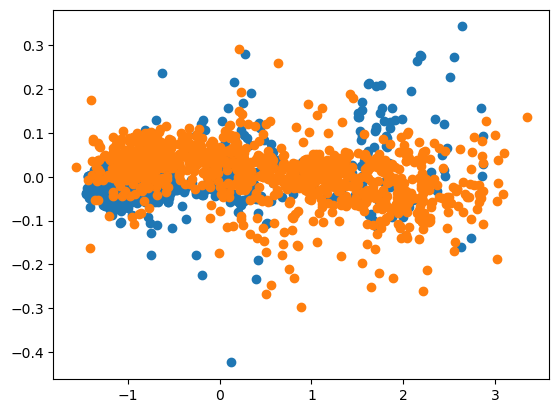

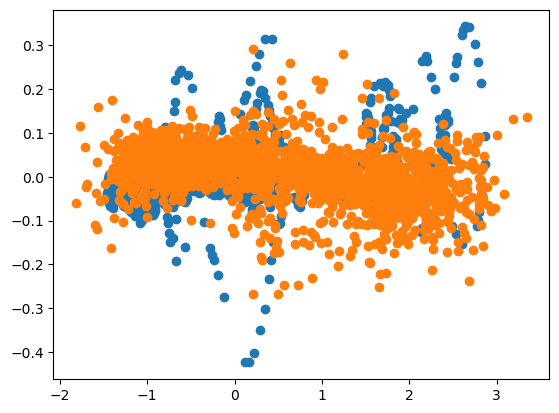

In [21]:
pca = PCA(2)
pca_res = pca.fit_transform(x2)

# 使用随机索引 减少点数
indexe1=np.random.permutation(4000)[:1000]
print(indexe1.shape)

indexe2=np.random.permutation( range(4000,8000) )[:1000]
print(indexe2.shape)


plt.figure()
plt.scatter(pca_res[indexe1,0],pca_res[indexe1,1])
plt.scatter(pca_res[indexe2,0],pca_res[indexe2,1])

plt.figure()
plt.scatter(pca_res[:2000,0],pca_res[:2000,1])
plt.scatter(pca_res[4000:6000,0],pca_res[4000:6000,1])

In [22]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    
tsne_results = tsne.fit_transform(x2)           
print(tsne_results.shape)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 8000 samples in 0.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.023004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.496780
[t-SNE] KL divergence after 500 iterations: 1.014007
(8000, 2)


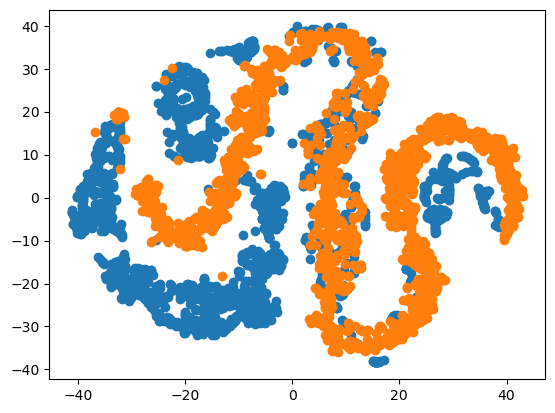

In [23]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[4000:6000,0],tsne_results[4000:6000,1])
# plt.savefig('tsne',dpi=500)

In [24]:
import matplotlib.pyplot as plt


training_data = np.load(trainset_config['train_data_path'])
training_data = np.array(training_data)
x = torch.from_numpy(training_data).float().cuda()

x = x[30:31]

latent_x = embedder(x)

latent_x = latent_x.permute(0,2,1)
print(latent_x.shape)


torch.Size([1, 3, 30])


In [25]:
inverted_x = latent_x

with torch.no_grad():        
    for t in range(0, T-1, 1):                       
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          
        epsilon_theta = net((inverted_x, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        inverted_x = ( torch.sqrt(Alpha_bar[t+1]) * (inverted_x - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                                     torch.sqrt(1-Alpha_bar[t+1])* epsilon_theta
  

In [26]:
print(inverted_x.shape)
criterion = nn.MSELoss(reduction="mean")
RMSE = torch.sqrt(criterion(latent_x, inverted_x))
print(RMSE)


torch.Size([1, 3, 30])
tensor(0.8111, device='cuda:0', grad_fn=<SqrtBackward0>)


In [27]:
recove = inverted_x

with torch.no_grad():        
    for t in range(T-1, 0, -1):                       
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          
        epsilon_theta = net((recove, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        recove = ( torch.sqrt(Alpha_bar[t-1]) * (recove - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                              torch.sqrt(1-Alpha_bar[t-1])* epsilon_theta

In [28]:
print(latent_x.shape)
print(recove.shape)

criterion = nn.MSELoss(reduction="mean")
RMSE = torch.sqrt(criterion(latent_x, recove))
print(RMSE)

torch.Size([1, 3, 30])
torch.Size([1, 3, 30])
tensor(0.0034, device='cuda:0', grad_fn=<SqrtBackward0>)


(1, 30, 6)
(30,)
(1, 30, 6)


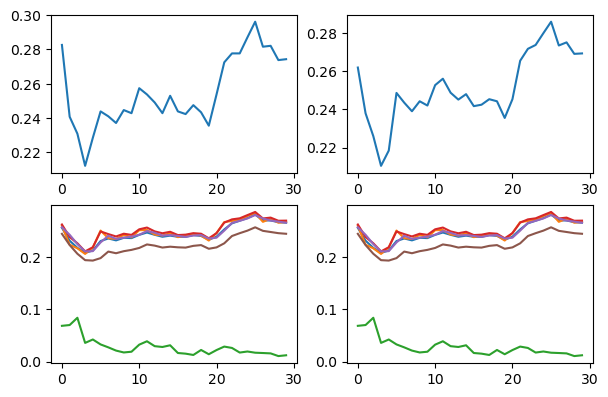

In [29]:
x_plot = x.cpu().numpy()
print(x_plot.shape)
print(x_plot[0][:,1].shape)

recove_plot = recovery(recove.permute(0, 2, 1)).detach().cpu().numpy()
print(recove_plot.shape)

# inverted_plot = inverted_x.permute(0, 2, 1).cpu().numpy()  


fig = plt.figure(figsize=(7,7))

plt.subplot(3,2,1)
plt.plot(x_plot[0][:,3])      

plt.subplot(3,2,2)
plt.plot(recove_plot[0][:,3])      


plt.subplot(3,2,3)
plt.plot(recove_plot[0][:,:])  

plt.subplot(3,2,4)
plt.plot(recove_plot[0][:,:]) 


# plt.subplot(3,2,5)
# plt.plot(inverted_plot[0][:,:]) 